<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Assignment1_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Importing libraries that will be used 
import numpy as np
import os
import tarfile
import re
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


# Loading dataset

In [21]:
# Untar the dataset
my_tar = tarfile.open('/content/lingspam_public.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()
train_path = '/content/lingspam_public/lemm_stop/part1'  # for training      #spams: spmsg*.txt
test_path = '/content/lingspam_public/lemm_stop/part10'   # for testing

training set:
number of spams: 48
number of not_spams: 241


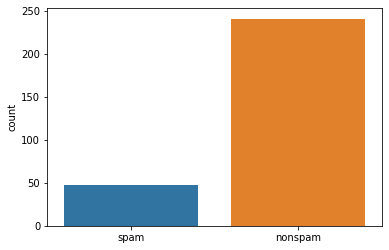

number of doc: 289

testing set:
number of spams: 49
number of not_spams: 242


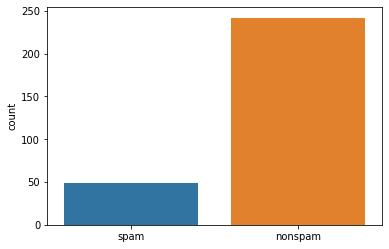

number of doc: 291


In [22]:
# Changing the data format of the dataset
def to_dict (path):
  data_dict = dict()
  data_dict[1] = []   # Spam 
  data_dict[0] = []   # Not Spam
  for file in os.listdir(path):  
    doc = open (path + '/'+ file, 'r')
    if 'spmsg' in file:
      data_dict[1].append(doc.read())
    else:
      data_dict[0].append(doc.read())
  print ('number of spams: {}'.format(len(data_dict[1])))
  print ('number of not_spams: {}'.format(len(data_dict[0])))
  sns.countplot(x=['spam']* len(data_dict[1])+['nonspam']* len(data_dict[0]))
  plt.show()  
  n_docs = len(os.listdir(path))
  return data_dict, n_docs

print('training set:')
training, n_docs_train = to_dict (train_path)
print('number of doc: {}'.format(n_docs_train))

print('\ntesting set:')
testing, n_docs_test = to_dict (test_path)
print('number of doc: {}'.format(n_docs_test))

# Data formating for using functions built in Sklearn
X_train = training[0]+ training[1]
y_train = [0]*len(training[0]) + [1]*len(training[1])

X_test = testing[0]+ testing[1]
y_true = [0]*len(testing[0]) + [1]*len(testing[1])


# Building a Naive Bayes classifier from scratch

In [23]:
# Defining some util functions 

## Defining function to tokenize the documents
def tokenizer (doc):
  doc = doc.lower() # Lowercase documents
  return re.split("\W+", doc)   # return a list of tokens without punctuations

## Defining a function to count frequency of words in each class
def count_words(data_dict):
  tf = {}
  tf[0], tf[1] = {}, {}
  all_docs = data_dict[0] + data_dict[1]
  temp0, temp1 = {},{}
  for doc in data_dict[0]:
    for token in tokenizer(doc):
      temp0[token] = temp0.get(token, 0)+1
    tf[0] = temp0
  for doc in data_dict[1]: 
    for token in tokenizer(doc):
      temp1[token] = temp1.get(token, 0)+1
    tf[1] = temp1
  # print('sum of tf0: {}, sum of tf1 {}'. format(sum(tf[0].values()), sum(tf[1].values())))
  return tf

## Defining a function to store tokens in classes with two different BOWS
def to_bow (data_dict):
  bows = {}
  bows[0], bows[1] = [], []
  for doc in data_dict[0]:
    bows[0].extend(tokenizer(doc))
  for doc in data_dict[1]:
    bows[1].extend(tokenizer(doc))
  return bows

## Defining a function to calculate log prior for each class
### Return a dict of classes' log priors
def logprior(data_dict, n_docs):
  logprior = {}
  n_spams = len(data_dict[1])
  n_nonspams = len(data_dict[0])
  print('length of spams: {}, nonspam: {}'.format(n_spams, n_nonspams))
  logprior[1] = np.log(n_spams/n_docs)
  logprior[0] = np.log(n_nonspams/n_docs)
  return logprior



In [24]:
# Defining TRAINING and TESTING functions

## Defining a function to train the Naive Bayes model 
### Returning logpriors of classes, a word loglikelihood list , set of vocabulary
def train_NB (training, alpha):
  bows = to_bow (training) 
  set_V = set(to_bow (training)[1] + to_bow (training)[0])
  tf = count_words(training)
  logpriors = logprior(training,n_docs_train)
  # calculating loglikelihood for each class
  loglikelihood = {}
  loglikelihood[0], loglikelihood[1] = {}, {}
  for c in training.keys():
    bow_c = bows[c]
    # print('.....length of bow {}:  {}.......'.format(c, len(bow_c)))
    loglikelihood_c = {}
    for w in set_V:
      if w in tf[c]:
        count_w = tf[c][w]  
      else:
        count_w = 0
      # print('count ---{} ---in c: {} '.format(w, count_w))
      loglikelihood_w = np.log((count_w + alpha)/(len(bow_c)+(len(set_V)*alpha)))
      loglikelihood_c[w] = loglikelihood_w
    loglikelihood[c] = loglikelihood_c
  return logpriors, loglikelihood, set_V


## Defining a function for NaiveBayes testing, returning predicted class
def test_NB (testing):
  prediction = []
  X_test = testing[0]+ testing[1]
  # Recalling BOW, log prior of each class, and vocabulary from training
  spam_bow = training_result[1][1]
  nonspam_bow = training_result[1][0]
  spam_logprior = training_result[0][1]
  nonspam_logprior = training_result[0][0]
  set_V = training_result[2]
  
  ## Calculating probability of class occurred given trained class priors,
  ## and trained word likelihoods
  for doc in X_test:
    spam_loglikelihoods, nonspam_loglikelihoods = [], []
    spam_score=0
    nonspam_score = 0
    for w in tokenizer(doc):
      if w not in set_V: 
        continue
      if w in spam_bow.keys():
        spam_score += spam_bow[w]
      if w in nonspam_bow.keys():
        nonspam_score += nonspam_bow[w]
    spam_score += spam_logprior
    nonspam_score += nonspam_logprior

    ## Determining class by taking class
    if spam_score > nonspam_score:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [25]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred)))
  print('F1 score: {}'.format(sklearn.metrics.f1_score(y_true, y_pred)))
  print(classification_report(y_true, y_pred))


In [26]:
# Testing alphas
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for alpha in alphas:
  print('---------------------------- \nalpha = {}'.format(alpha))
  # Training model on the training set
  training_result = train_NB (training, alpha)

  # Making prediction
  y_pred = test_NB (testing)
  ## on training set
  print('Model performance on training set:')
  printing_eval_scores (y_train, test_NB(training))

  ## on test set
  print('\nModel performance on test set:')
  printing_eval_scores (y_true, y_pred)

---------------------------- 
alpha = 0.1
length of spams: 48, nonspam: 241
Model performance on training set:
accuracy score: 0.9965397923875432
precision score: 0.9795918367346939
recall score: 1.0
F1 score: 0.9896907216494846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       0.98      1.00      0.99        48

    accuracy                           1.00       289
   macro avg       0.99      1.00      0.99       289
weighted avg       1.00      1.00      1.00       289


Model performance on test set:
accuracy score: 0.9347079037800687
precision score: 0.7678571428571429
recall score: 0.8775510204081632
F1 score: 0.819047619047619
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       242
           1       0.77      0.88      0.82        49

    accuracy                           0.93       291
   macro avg       0.87      0.91      0.89       291
weighted

In [27]:
selected_alpha = 1
# Training model on the training set
training_result = train_NB (training, alpha = selected_alpha)

# Making prediction
y_pred = test_NB (testing)

## on training set
print('Model performance on training set:')
printing_eval_scores (y_train, test_NB(training))

## on test set
print('--------------------------------')
print('\nModel performance on test set:')
printing_eval_scores (y_true, y_pred)

length of spams: 48, nonspam: 241
Model performance on training set:
accuracy score: 0.9896193771626297
precision score: 0.9411764705882353
recall score: 1.0
F1 score: 0.9696969696969697
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       241
           1       0.94      1.00      0.97        48

    accuracy                           0.99       289
   macro avg       0.97      0.99      0.98       289
weighted avg       0.99      0.99      0.99       289

--------------------------------

Model performance on test set:
accuracy score: 0.9381443298969072
precision score: 0.7540983606557377
recall score: 0.9387755102040817
F1 score: 0.8363636363636363
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       242
           1       0.75      0.94      0.84        49

    accuracy                           0.94       291
   macro avg       0.87      0.94      0.90       291
weighted avg    

confusion metrics 
 [[227  15]
 [  3  46]]


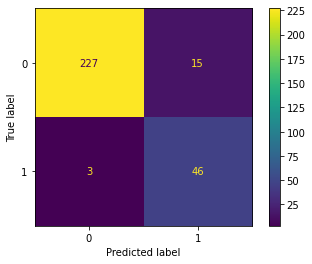

In [28]:
# printing and visualize the confusion metrics
cm = confusion_matrix(y_true, y_pred)
print('confusion metrics \n', cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot(include_values = True, values_format = 'd')


# Building a Naive Bayes classifier from Sklearn

on training set
accuracy score: 0.9965397923875432
precision score: 0.9795918367346939
recall score: 1.0
F1 score: 0.9896907216494846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       0.98      1.00      0.99        48

    accuracy                           1.00       289
   macro avg       0.99      1.00      0.99       289
weighted avg       1.00      1.00      1.00       289


-------------------------------
on test set
accuracy score: 0.9896907216494846
precision score: 1.0
recall score: 0.9387755102040817
F1 score: 0.968421052631579
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       242
           1       1.00      0.94      0.97        49

    accuracy                           0.99       291
   macro avg       0.99      0.97      0.98       291
weighted avg       0.99      0.99      0.99       291

confusion metrics 
 [[242   0]
 [  3  46]]


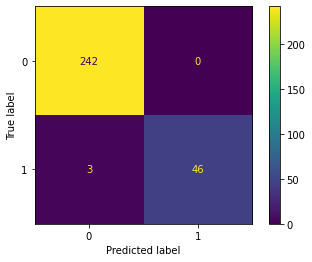

In [29]:
# Creating a vectorizer model that converts a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(lowercase = True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
# Converting  sparse matrix to a dense matrix
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

# Creating NB classifier
nb_2 = MultinomialNB()

# Fitting the model into the training set for training
nb_2.fit(X_train_vec, y_train)

# Using NB clssifier to make prediction on test set
y_pred_2 = nb_2.predict(X_test_vec)

# Printing model performance 
## on training set
print ('on training set')
printing_eval_scores (y_train, nb_2.predict(X_train_vec))

## on test set
print ('\n-------------------------------\non test set')
printing_eval_scores (y_true, y_pred_2)

# printing and visualize the confusion metrics
cm = confusion_matrix(y_true, y_pred_2)
print('confusion metrics \n', cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot(include_values = True, values_format = 'd')
